In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.mul import GainesMul
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
rng = "Sobol"

--- 0.23099994659423828 seconds ---
input 0 error:  tensor(-0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
input 1 error:  tensor(-0.0117, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0820, device='cuda:0') tensor(0.0703, device='cuda:0')
RMSE 0.02327653056192009
bias -0.00560234375


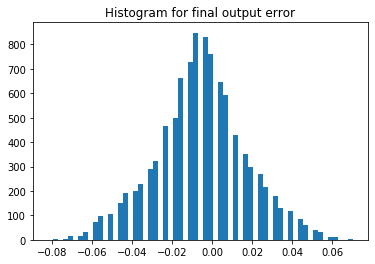

--- 0.182999849319458 seconds ---
input 0 error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
input 1 error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.0195, device='cuda:0') tensor(0.0195, device='cuda:0')
RMSE 0.0066845970626975715
bias -0.00287109375


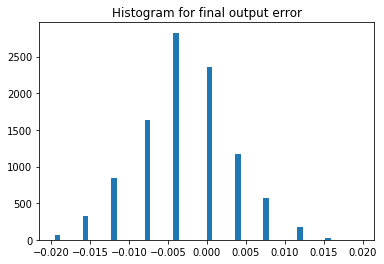

In [4]:
col = 10000
modes = ["bipolar", "unipolar"]
bitwidth = 8

for mode in modes:
    if mode is "unipolar":
        input_prob_0 = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        input_prob_1 = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    elif mode is "bipolar":
        input_prob_0 = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        input_prob_1 = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_mul = GainesMul(mode).to(device)

    oVec = torch.mul(input_prob_0, input_prob_1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    prob_0_PE = ProgressiveError(input_prob_0, mode=mode).to(device)
    prob_1_PE = ProgressiveError(input_prob_1, mode=mode).to(device)

    oVecPE = ProgressiveError(oVec, mode=mode).to(device)

    prob_0_Source = SourceGen(input_prob_0, bitwidth, mode=mode)().to(device)
    prob_1_Source = SourceGen(input_prob_1, bitwidth, mode=mode)().to(device)

    iVecRNG0 = RNG(bitwidth, 1, rng)().to(device)
    iVecRNG1 = RNG(bitwidth, 1111, rng)().to(device)
    prob_0_BS = BSGen(prob_0_Source, iVecRNG0).to(device)
    prob_1_BS = BSGen(prob_1_Source, iVecRNG1).to(device)

    with torch.no_grad():
        start_time = time.time()
        idx = torch.zeros(input_prob_0.size()).type(torch.long).to(device)
        for i in range(2**bitwidth):
            #print(i)
            iBS_0 = prob_0_BS(idx + i)
            iBS_1 = prob_1_BS(idx + i)

            prob_0_PE.Monitor(iBS_0)
            prob_1_PE.Monitor(iBS_1)

            oVecU = dut_mul(iBS_0, iBS_1)   
            oVecPE.Monitor(oVecU)
    #         print(iBS)
    #         print(oVecU)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input 0 error: ", torch.min(prob_0_PE()[1]), torch.max(prob_0_PE()[1]))
        print("input 1 error: ", torch.min(prob_1_PE()[1]), torch.max(prob_1_PE()[1]))

        print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
        result_pe = oVecPE()[1].cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("bias", sum(result_pe)/len(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()